# Lecture 1: PyTorch Fundamentals & Tensors

## 1. Setup and Installation
If you are running this locally, you'll need to install PyTorch first: pip install torch torchvision torchaudio

In [1]:
import torch
import numpy as np

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu126


## 2. Creating Tensors
Tensors can be created from Python lists, NumPy arrays, or directly with built-in functions.

In [2]:
# 1. From a list (Scalar)
scalar = torch.tensor(7)
print(f"Scalar: {scalar}, Dimensions: {scalar.ndim}")

# 2. From a list (Vector)
vector = torch.tensor([1, 2, 3])
print(f"Vector: {vector}, Shape: {vector.shape}")

# 3. From a NumPy array
np_array = np.array([1.0, 2.0, 3.0])
tensor_from_np = torch.from_numpy(np_array)

# 4. Common initializations
zeros = torch.zeros((2, 3))    # 2x3 matrix of zeros
ones = torch.ones((2, 3))      # 2x3 matrix of ones
rand = torch.rand((3, 3))      # 3x3 matrix of random numbers [0, 1]

Scalar: 7, Dimensions: 0
Vector: tensor([1, 2, 3]), Shape: torch.Size([3])


## 3. Tensor Operations
Operations in PyTorch are nearly identical to NumPy.

In [3]:
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])

# Addition
print(x + y) # or torch.add(x, y)

# Matrix Multiplication (Crucial for Deep Learning)
tensor_a = torch.rand(3, 2)
tensor_b = torch.rand(2, 4)
# Use @ or torch.matmul
result = tensor_a @ tensor_b 
print(f"Result shape: {result.shape}")

tensor([5, 7, 9])
Result shape: torch.Size([3, 4])


## 4. Reshaping and Squeezing
Often in ML, you need to change the "shape" of your data to fit into a model layer.

In [4]:
x = torch.arange(1, 10) # [1, 2, 3, 4, 5, 6, 7, 8, 9]
x_reshaped = x.reshape(3, 3)

# 'view' is similar to reshape but shares memory with the original tensor
x_view = x.view(9, 1)

print("x:", x)

print("x_reshaped:", x_reshaped)

print("x_view:" ,x_view)

x: tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
x_reshaped: tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
x_view: tensor([[1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])


## 5. Moving to GPU
One of the main reasons we use PyTorch over NumPy is GPU acceleration.

In [5]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Move tensor to device
x_gpu = x.to(device)

print("x_gpu:", x_gpu)

Using device: cpu
x_gpu: tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


# Lecture 2: Autograd & The Computational Graph

## 1. The requires_grad Flag
By default, PyTorch tensors don't track their history. To calculate gradients, you must tell PyTorch that a tensor is part of a mathematical "tree" that needs to be differentiated.

In [6]:
import torch

# Create a tensor and tell it to track gradients
x = torch.tensor(2.0, requires_grad=True)

# Define a function: y = x^2 + 5
y = x**2 + 5

print(f"Input x: {x}")
print(f"Output y: {y}")

Input x: 2.0
Output y: 9.0


## 2. Backpropagation (The .backward() call)
When you call .backward(), PyTorch walks backward from the output to the input, calculating the derivative of the function at that specific point.

In [7]:
# Calculate the gradient (dy/dx)
y.backward()

# The gradient dy/dx = 2x. 
# Since x = 2, the gradient should be 2*(2) = 4.
print(f"Gradient of y with respect to x: {x.grad}")

Gradient of y with respect to x: 4.0


## 3. Preventing Gradient Tracking
When you are evaluating a model (testing it), you don't want to calculate gradients because it wastes memory and speed. You use torch.no_grad().

In [8]:
# This is how you "turn off" the math tracking
with torch.no_grad():
    z = x * 2
    print(f"Does z have a gradient function? {z.grad_fn}") # Returns None

print(f"Does y have a gradient function? {y.grad_fn}") # Returns a Power object

Does z have a gradient function? None
Does y have a gradient function? <AddBackward0 object at 0x7bdbaf5213c0>


## 4. Zeroing Gradients
In PyTorch, gradients accumulate (they add up) by default. This is a common source of bugs for beginners. You must clear them before calculating a new one.

In [9]:
# If we run backward again without clearing...
y = x**2
y.backward()
print(f"Gradient after 1st run: {x.grad}")

y = x**2
y.backward()
print(f"Gradient after 2nd run (Accumulated!): {x.grad}") # It adds to the previous 4!

# How to fix it:
x.grad.zero_()
print(f"Gradient after zeroing: {x.grad}")

Gradient after 1st run: 8.0
Gradient after 2nd run (Accumulated!): 12.0
Gradient after zeroing: 0.0


# Lecture 3: Linear Regression from Scratch

## 1. The Setup
We want to model the relationship
$y = wx + b$.$w$ (weight): 
The slope.$b$ (bias): The intercept.

In [10]:
import torch
import matplotlib.pyplot as plt

# 1. Create 'True' data with some noise
torch.manual_seed(42)
X = torch.randn(100, 1) * 10
# True relationship: y = 2x + 5
y_true = 2 * X + 5 + torch.randn(100, 1) * 2 

# 2. Initialize our parameters (Randomly)
# We set requires_grad=True because we want to optimize these!
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

print(f"Initial w: {w.item():.4f}, b: {b.item():.4f}")

Initial w: 0.3932, b: -0.2148


## 2. The Training Loop
To "learn," we repeat four steps:Forward Pass: Predict $y$ using current $w$ and $b$.Loss Calculation: Calculate the Mean Squared Error (MSE).Backward Pass: Use .backward() to find the gradients.Optimization: Update $w$ and $b$ by moving in the opposite direction of the gradient.

In [11]:
lr = 0.001 # Learning Rate
epochs = 100

for epoch in range(epochs):
    # 1. Forward Pass
    y_pred = X * w + b
    
    # 2. Compute Loss (Mean Squared Error)
    loss = torch.mean((y_pred - y_true)**2)
    
    # 3. Backward Pass
    loss.backward()
    
    # 4. Update Parameters
    # Wrap in no_grad because updating weights shouldn't be tracked in the graph
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad
        
        # IMPORTANT: Manually zero the gradients for the next epoch
        w.grad.zero_()
        b.grad.zero_()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

print(f"\nFinal Learned w: {w.item():.4f}, b: {b.item():.4f}")

Epoch 10: Loss = 35.3256
Epoch 20: Loss = 28.9034
Epoch 30: Loss = 27.8249
Epoch 40: Loss = 26.8579
Epoch 50: Loss = 25.9297
Epoch 60: Loss = 25.0378
Epoch 70: Loss = 24.1807
Epoch 80: Loss = 23.3572
Epoch 90: Loss = 22.5659
Epoch 100: Loss = 21.8055

Final Learned w: 2.0294, b: 0.7495


## 3. Visualizing the Result

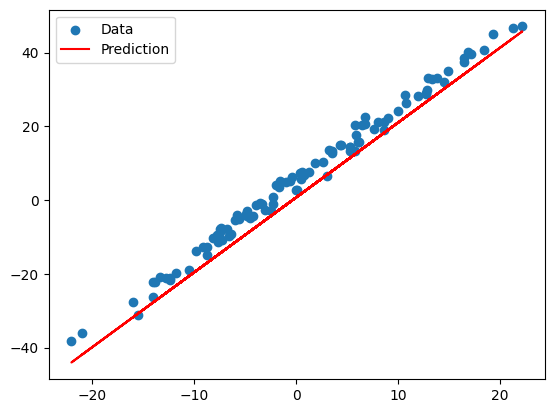

In [12]:
plt.scatter(X.numpy(), y_true.numpy(), label="Data")
plt.plot(X.numpy(), (X * w + b).detach().numpy(), color='red', label="Prediction")
plt.legend()
plt.show()

# Lecture 4: The PyTorch Workflow (nn.Module & Optimizer)

## 1. Defining the Model
In PyTorch, all neural networks must inherit from torch.nn.Module.

In [13]:
import torch
from torch import nn # nn contains all the building blocks

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of manual w and b, we use nn.Linear
        # 1 input feature (x), 1 output feature (y)
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # This defines the computation performed at every call
        return self.linear_layer(x)

# Instantiate the model
model = LinearRegressionModel()
print(list(model.parameters())) # PyTorch automatically created w and b for you!

[Parameter containing:
tensor([[-0.0098]], requires_grad=True), Parameter containing:
tensor([-0.7605], requires_grad=True)]


## 2. Loss Function and Optimizer
Instead of writing the MSE math ourselves and manually subtracting gradients, we use built-in tools.

In [14]:
# 1. Setup a Loss Function
loss_fn = nn.MSELoss() 

# 2. Setup an Optimizer (Stochastic Gradient Descent)
# We tell it which parameters to optimize and the learning rate
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

## 3. The Clean Training Loop
Notice how much cleaner this is. No manual w -= lr * w.grad.

In [15]:
# Create data (same as before)
X = torch.randn(100, 1)
y_true = 3 * X + 2 + torch.randn(100, 1) * 0.1

epochs = 100

for epoch in range(epochs):
    model.train() # Put model in training mode

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_true)

    # 3. Optimizer zero grad (Wipe the slate clean)
    optimizer.zero_grad()

    # 4. Perform Backpropagation
    loss.backward()

    # 5. Step the optimizer (Update the weights)
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item()}")

Epoch: 0 | Loss: 14.744170188903809
Epoch: 20 | Loss: 7.181203842163086
Epoch: 40 | Loss: 3.5418267250061035
Epoch: 60 | Loss: 1.7703059911727905
Epoch: 80 | Loss: 0.8976189494132996


## 4. Making Predictions (Inference)
When testing your model, you must use model.eval() and the inference_mode context manager.

In [16]:
model.eval() # Turns off things like Dropout or Batchnorm (not used here, but good habit)
with torch.inference_mode(): # Faster, more memory efficient version of no_grad()
    predictions = model(X)

print(f"Learned Parameters: {model.state_dict()}")

Learned Parameters: OrderedDict({'linear_layer.weight': tensor([[2.3415]]), 'linear_layer.bias': tensor([1.6665])})


# Lecture 5: Non-Linearity & Classification

## 1. The "Problem" with Linear Layers
If your data isn't a straight line, a linear model will fail. We solve this by adding a non-linear "trigger" after a linear layer. The most common one is ReLU (Rectified Linear Unit), which simply turns all negative numbers into zero.

## 2. Building a Non-Linear Model
We will use a hidden layer and an activation function to build a model that can handle more complex data.

In [17]:
import torch
from torch import nn

class SimpleNeuralNet(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), # The "magic" non-linear step
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

# Create an instance (e.g., for data with 2 features, 10 hidden neurons, 1 output)
model = SimpleNeuralNet(2, 10, 1)
print(model)

SimpleNeuralNet(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


## 3. Understanding Binary Cross Entropy (BCE)
For regression, we used MSE. For classification (Yes/No, 0/1), we use Binary Cross Entropy. This measures how "far off" our predicted probability is from the actual label.

In [18]:
# 1. Binary Cross Entropy with Logits (more numerically stable)
loss_fn = nn.BCEWithLogitsLoss()

# 2. Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## 4. The Sigmoid Function
Our model outputs "logits" (raw numbers). To turn these into probabilities between 0 and 1, we pass them through a Sigmoid function.

In [19]:
# Simulated raw output from a model
logits = torch.tensor([[-1.2], [0.5], [3.0]])

# Convert to probabilities
probs = torch.sigmoid(logits)

print(f"Logits: {logits.flatten()}")
print(f"Probabilities: {probs.flatten()}")

Logits: tensor([-1.2000,  0.5000,  3.0000])
Probabilities: tensor([0.2315, 0.6225, 0.9526])


# Lecture 6: Data Pipelines (Dataset & DataLoader)

## 1. The Concept: Why Batches?
If you have 100,000 rows of data, calculating the gradient for all of them at once is slow and memory-intensive. Instead, we split the data into small chunks (batches), usually of 32, 64, or 128 samples.

## 2. The Dataset Class
This is where your data "lives." It handles loading and preprocessing.

__len__: Returns the total number of items.

__getitem__: Returns one specific sample (and its label) given an index.

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomNumbersDataset(Dataset):
    def __init__(self, start, end):
        # Create some dummy data: X is the number, y is the number * 2
        self.samples = torch.arange(start, end, dtype=torch.float32).reshape(-1, 1)
        self.labels = self.samples * 2

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# Instantiate
dataset = CustomNumbersDataset(0, 100)
print(f"Dataset length: {len(dataset)}")

Dataset length: 100


## 3. The DataLoader Class
The DataLoader is an iterable. It wraps the Dataset and automatically manages batching, shuffling, and even using multiple CPU cores to load data faster.

In [21]:
# Batch size of 8. Shuffle=True is vital for training!
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Let's look at one batch
first_batch_features, first_batch_labels = next(iter(train_loader))

print(f"Batch Features shape: {first_batch_features.shape}") # [8, 1]
print(f"Batch Labels shape: {first_batch_labels.shape}")     # [8, 1]

Batch Features shape: torch.Size([8, 1])
Batch Labels shape: torch.Size([8, 1])


## 4. The Updated Training Loop
Now, our training loop has a "nested" loop. We loop through epochs (entire dataset), and inside each epoch, we loop through batches.

In [22]:
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

epochs = 3
for epoch in range(epochs):
    # Loop through batches
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # 1. Forward pass
        y_pred = model(X_batch)
        
        # 2. Loss
        loss = loss_fn(y_pred, y_batch)
        
        # 3. Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch+1} completed.")

Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.


# Lecture 7: Convolutional Neural Networks (CNNs)

## A CNN typically consists of three main operations:

Convolution (nn.Conv2d): Slides a small window (filter) over the image to find edges, textures, or shapes.

Activation (nn.ReLU): Adds non-linearity.

Pooling (nn.MaxPool2d): Reduces the size of the image, keeping only the most important information (the "strongest" pixels).

## 2. The Convolutional Layer (Conv2d)
When you define a Conv2d layer, you need to know:

in_channels: 1 for Grayscale, 3 for RGB (Color).

out_channels: Number of filters (patterns) the model will try to learn.

kernel_size: The size of the sliding window (usually 3x3 or 5x5).

In [23]:
import torch
from torch import nn

# Create a dummy "image": [Batch, Color_Channels, Height, Width]
dummy_image = torch.randn(1, 3, 64, 64) 

# Define a convolution layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

# Apply it
output = conv_layer(dummy_image)
print(f"Original shape: {dummy_image.shape}")
print(f"Shape after convolution: {output.shape}") # Height/Width stay same due to padding=1

Original shape: torch.Size([1, 3, 64, 64])
Shape after convolution: torch.Size([1, 16, 64, 64])


## 3. Building a TinyVGG Style CNN
This is a famous architecture for learning image classification from scratch.

In [24]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # Halves the height and width
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # Turns the 2D feature maps into a 1D vector
            # The input features here depend on the image size after pooling
            nn.Linear(in_features=hidden_units * 32 * 32, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block(x)
        return self.classifier(x)

# Model for a 64x64 RGB image with 2 classes
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=2)

## 4. Flattening: The Bridge
The most common error in CNNs is the transition between the Convolutional layers (3D) and the Linear layers (1D). nn.Flatten() takes a tensor of shape (Batch, Channels, Height, Width) and squashes it into (Batch, Channels * Height * Width).

# Lecture 8: Transfer Learning & Pre-trained Models

## 1. The Strategy
Instead of starting with random weights, we use a model that already knows how to see (recognize edges, eyes, wheels, etc.).

Pick a backbone: Use a pre-trained model (e.g., ResNet, EfficientNet).

Freeze it: Prevent the pre-trained weights from changing during initial training.

Replace the "Head": Swap the final linear layer with one that fits your specific number of classes.

## 2. Loading a Pre-trained Model
PyTorch makes this easy through torchvision.models.

In [25]:
import torch
import torchvision
from torch import nn

# 1. Get the pre-trained weights
weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights)

# 2. Freeze all base layers (Parameters won't update during backprop)
for param in model.parameters():
    param.requires_grad = False

print(f"Original ResNet Classifier: {model.fc}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 55.1MB/s]


Original ResNet Classifier: Linear(in_features=512, out_features=1000, bias=True)


## 3. Modifying the Classifier
The original ResNet was trained on 1,000 classes. If you only want to classify "Dogs vs. Cats," you change the last layer.

In [26]:
# 3. Replace the last layer (fc = fully connected)
# We know ResNet18's last layer has 512 input features
model.fc = nn.Linear(in_features=512, out_features=2) 

# Now, only the weights in model.fc will be trained!
print(f"New Classifier: {model.fc}")

New Classifier: Linear(in_features=512, out_features=2, bias=True)


## 4. Data Transformation
When using pre-trained models, you must use the same preprocessing (scaling, cropping, normalization) that the original model was trained on.

In [27]:
# Get the transforms required by the weights
preprocess = weights.transforms()

print(f"Required Transforms:\n{preprocess}")
# This will show you things like: Resize(size=[224]), Normalize(mean=[0.485...])

Required Transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


# Lecture 9: Saving, Loading, and the state_dict

In PyTorch, we don't usually save the entire model object (the "body"). Instead, we save the state_dict (the "brain"). This is a Python dictionary that maps each layer to its learned weight and bias tensors.

## 1. Inspecting the state_dict
Before saving, it’s helpful to see what’s actually inside.

In [28]:
import torch
from torch import nn

# Create a simple model from scratch
model = nn.Sequential(
    nn.Linear(3, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

print("--- Model's State Dict Keys ---")
for param_tensor in model.state_dict():
    print(f"{param_tensor} \t shape: {model.state_dict()[param_tensor].size()}")

--- Model's State Dict Keys ---
0.weight 	 shape: torch.Size([5, 3])
0.bias 	 shape: torch.Size([5])
2.weight 	 shape: torch.Size([1, 5])
2.bias 	 shape: torch.Size([1])


## 2. Saving the Weights
We use torch.save(). While you can name the file anything, the community standard is .pt or .pth.

In [29]:
from pathlib import Path

# 1. Setup directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create save path
MODEL_NAME = "09_model_scratch.pth"
SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save only the state_dict
print(f"Saving model to: {SAVE_PATH}")
torch.save(obj=model.state_dict(), f=SAVE_PATH)

Saving model to: models/09_model_scratch.pth


## 3. Loading the Weights
To load, you must first recreate the exact same architecture (the "body"). You cannot load weights into a model with different layer sizes.

In [30]:
# 1. Instantiate the model class again (must be identical structure)
loaded_model = nn.Sequential(
    nn.Linear(3, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

# 2. Load the file from disk
saved_weights = torch.load(f=SAVE_PATH)

# 3. Load the weights into the model instance
loaded_model.load_state_dict(saved_weights)

print("Model weights loaded successfully!")

Model weights loaded successfully!


## 4. Moving to Evaluation Mode
This is the part most beginners forget. When you load a model to make predictions, you must call .eval(). This turns off layers like Dropout or BatchNorm that behave differently during training.

In [31]:
loaded_model.eval()

with torch.inference_mode(): # Faster, uses less memory than no_grad()
    dummy_input = torch.randn(1, 3)
    prediction = loaded_model(dummy_input)
    print(f"Prediction: {prediction}")

Prediction: tensor([[-0.8423]])


# Lecture 10: NLP – Tokens, Embeddings, and RNNs

## 1. Tokenization: Turning Words into IDs
The first step is breaking a sentence into "tokens" (words or characters) and assigning each unique token a number.

In [32]:
import torch
from torch import nn

# Our raw data
text = "i love building from scratch"
words = text.split()

# Create a vocabulary mapping
vocab = {word: i for i, word in enumerate(set(words))}
print(f"Vocab Mapping: {vocab}")

# Convert sentence to integers
sequence = torch.tensor([vocab[w] for w in words])
print(f"Integer Sequence: {sequence}")

Vocab Mapping: {'love': 0, 'scratch': 1, 'i': 2, 'from': 3, 'building': 4}
Integer Sequence: tensor([2, 0, 4, 3, 1])


## 2. The Embedding Layer (nn.Embedding)
An integer like 4 doesn't tell the model anything about a word's meaning. We use Embeddings—trainable vectors where words with similar meanings end up close to each other in mathematical space.

In [33]:
# Assume vocab size of 10, and we want each word to be a 5-number vector
embedding = nn.Embedding(num_embeddings=10, embedding_dim=5)

# Turn our sequence of IDs into a sequence of vectors
embedded_sentence = embedding(sequence)

print(f"Sequence Shape: {embedded_sentence.shape}") # [5 words, 5 dimensions]

Sequence Shape: torch.Size([5, 5])


## 3. The Recurrent Neural Network (RNN)
Standard models process all inputs at once. RNNs process words one-by-one, maintaining a Hidden State (memory) that carries information from the beginning of the sentence to the end.

In [34]:
# input_size=5 (embedding dim), hidden_size=12 (size of the 'memory' vector)
rnn = nn.RNN(input_size=5, hidden_size=12, batch_first=True)

# Add a batch dimension [Batch, Seq_Len, Features]
input_data = embedded_sentence.unsqueeze(0) 

# output: hidden states for every word
# hidden: the final 'summary' memory of the whole sentence
output, hidden = rnn(input_data)

print(f"Final Memory (Hidden State) Shape: {hidden.shape}")

Final Memory (Hidden State) Shape: torch.Size([1, 1, 12])


# Lecture 11: The Transformer & Self-Attention

## 1. The Core Idea: Attention
In the sentence: "The animal didn't cross the street because it was too tired," Self-Attention allows the model to link the word "it" back to "animal". If the sentence ended in "because it was too wide," the model would link "it" to "street".

## 2. Multi-Head Attention in PyTorch
PyTorch provides a powerful nn.MultiheadAttention layer, but for our "from scratch" path, we’ll see how it fits into a layer.

In [35]:
import torch
from torch import nn

# Parameters
embed_dim = 128  # Dimension of our word vectors
num_heads = 8    # Number of "attention heads" looking at different patterns

# Define the layer
attention_layer = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

# Create dummy input: [Sequence_Length, Batch_Size, Embed_Dim]
# (Note: Transformers often expect Seq_Len first unless batch_first=True)
query = torch.randn(10, 1, 128)
key = query
value = query

# attn_output: the new vectors for each word, informed by their neighbors
attn_output, attn_weights = attention_layer(query, key, value)

print(f"Attention Output Shape: {attn_output.shape}")

Attention Output Shape: torch.Size([10, 1, 128])


## 3. The Transformer Block
A Transformer isn't just attention; it’s a stack of Attention + Feed Forward layers with "Residual Connections" (skipping layers) to help gradients flow.

In [36]:
class SimpleTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim)
        )

    def forward(self, x):
        # 1. Attention + Residual Connection
        attn_out, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_out) # Add & Norm
        
        # 2. Feed Forward + Residual Connection
        ff_out = self.feed_forward(x)
        x = self.norm2(x + ff_out) # Add & Norm
        return x

model_block = SimpleTransformerBlock(128, 8)
print(model_block)

SimpleTransformerBlock(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (feed_forward): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
)


## 4. Positional Encoding
Since Transformers see the whole sentence at once, they don't naturally know the order of words (unlike RNNs). We have to "inject" the position of each word into the embedding using math (sines and cosines).